# Лабораторная работа 3. TF-IDF взвешивание терминов для векторизации текстов

**Задание 1.** Реализуйте векторизацию текстов на основе tf-idf метода взвешивания терминов. Предусмотрите задание размера словаря терминов, используемого для взвешивания. Можно код организовать отдельным модулем. Протестируйте свою реализацию метода.

In [ ]:
import pandas as pd
import nltk
import math
import numpy as np
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize

# Загрузка ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def preprocess(text):
    """Токенизация текста и приведение к нижнему регистру"""
    tokens = word_tokenize(text.lower())
    russian_stop_words = ['и', 'в', 'на', 'с', 'по', 'для', 'я', 'ты', 'он', 'она']

    # Последовательно применяем все фильтры
    filtered_tokens = [
        word for word in tokens
        if (word not in russian_stop_words
            and len(word) > 2
            and word.isalpha())
    ]

    return filtered_tokens

def build_vocabulary(documents, max_features=None):
    """
    Построение словаря терминов из документов
    documents - список документов, каждый документ - список токенов
    max_features - максимальное количество терминов в словаре
    """
    # Считаем общую частоту каждого термина во всех документах
    term_freq = Counter()
    for doc in documents:
        term_freq.update(doc)  # Увеличиваем счетчик для каждого термина в документе

    # Сортируем термины по убыванию частоты
    sorted_terms = sorted(term_freq.items(), key=lambda x: (-x[1], x[0]))

    # Если задано ограничение, берем только первые max_features терминов
    if max_features and len(sorted_terms) > max_features:
        sorted_terms = sorted_terms[:max_features]

    # Создаем словарь: термин -> индекс
    vocabulary = {}
    for idx, (term, freq) in enumerate(sorted_terms):
        vocabulary[term] = idx

    return vocabulary

def calculate_idf(documents, vocabulary):
    """
    Вычисление IDF (Inverse Document Frequency) для каждого термина
    IDF показывает, насколько редок термин во всей коллекции документов
    """
    total_docs = len(documents)
    idf_dict = {}

    # Для каждого термина в словаре считаем, в скольких документах он встречается
    for term in vocabulary:
        doc_count = 0
        for doc in documents:
            if term in doc:  # Если термин есть в документе
                doc_count += 1

        # Формула IDF с сглаживанием (smoothing)
        # log((общее_число_документов + 1) / (документов_с_термином + 1)) + 1
        idf_dict[term] = math.log((total_docs + 1) / (doc_count + 1)) + 1

    return idf_dict

def calculate_tfidf(documents, vocabulary, idf_dict):
    """
    Вычисление TF-IDF матрицы
    TF (Term Frequency) - частота термина в документе
    TF-IDF = TF * IDF
    """
    n_docs = len(documents)
    n_terms = len(vocabulary)

    # Создаем пустую матрицу (все нули)
    tfidf_matrix = np.zeros((n_docs, n_terms))

    # Для каждого документа
    for doc_idx, doc in enumerate(documents):
        # Считаем частоту каждого термина в текущем документе
        term_counts = Counter(doc)
        total_terms_in_doc = len(doc)

        # Для каждого термина в документе
        for term, count in term_counts.items():
            # Если термин есть в нашем словаре
            if term in vocabulary:
                term_idx = vocabulary[term]  # Получаем индекс термина

                # Вычисляем TF (нормализованная частота)
                tf = count / total_terms_in_doc

                # Вычисляем TF-IDF
                tfidf_matrix[doc_idx, term_idx] = tf * idf_dict[term]

    return tfidf_matrix

def my_tfidf_vectorizer(documents, max_features=None):
    """
    Основная функция TF-IDF векторизации
    Объединяет все шаги: построение словаря, расчет IDF, расчет TF-IDF
    """
    # Шаг 1: Строим словарь
    vocabulary = build_vocabulary(documents, max_features)

    # Шаг 2: Вычисляем IDF
    idf_dict = calculate_idf(documents, vocabulary)

    # Шаг 3: Вычисляем TF-IDF матрицу
    tfidf_matrix = calculate_tfidf(documents, vocabulary, idf_dict)

    return tfidf_matrix, vocabulary, idf_dict

# СОЗДАНИЕ ИСХОДНЫХ ДАННЫХ
data = {
    'document': [
        'Этот документ первый.',
        'Этот документ второй.',
        'И это третий документ.',
        'Документ четвертый отличается.'
    ]
}
df = pd.DataFrame(data)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print("1. Исходные данные:")
print(df)

1. Исходные данные:
                         document
0           Этот документ первый.
1           Этот документ второй.
2          И это третий документ.
3  Документ четвертый отличается.


In [ ]:
# ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ТЕКСТА
df['tokens'] = df['document'].apply(preprocess)  # Получаем списки токенов
print("2. После токенизации:")
for i, row in df.iterrows():
    print(f"   Документ {i+1}: {row['tokens']}")

2. После токенизации:
   Документ 1: ['этот', 'документ', 'первый']
   Документ 2: ['этот', 'документ', 'второй']
   Документ 3: ['это', 'третий', 'документ']
   Документ 4: ['документ', 'четвертый', 'отличается']


In [ ]:
# ВЕКТОРИЗАЦИЯ С ОГРАНИЧЕНИЕМ РАЗМЕРА СЛОВАРЯ
max_features = 5  # Ограничиваем словарь 5 терминами
print(f"3. Векторизация TF-IDF (словарь ограничен {max_features} терминами)")

# Применяем нашу реализацию TF-IDF
tfidf_matrix, vocabulary, idf_dict = my_tfidf_vectorizer(df['tokens'].tolist(), max_features)

# СОЗДАЕМ DATAFRAME ДЛЯ НАГЛЯДНОСТИ
# Получаем названия терминов в правильном порядке
feature_names = [term for term, idx in sorted(vocabulary.items(), key=lambda x: x[1])]

tfidf_df = pd.DataFrame(
    tfidf_matrix,
    columns=feature_names
)

3. Векторизация TF-IDF (словарь ограничен 5 терминами)


In [ ]:
print("4. Словарь терминов:")
for term, idx in sorted(vocabulary.items(), key=lambda x: x[1]):
    print(f"   '{term}' -> индекс {idx}, IDF: {idf_dict[term]:.4f}")


4. Словарь терминов:
   'документ' -> индекс 0, IDF: 1.0000
   'этот' -> индекс 1, IDF: 1.5108
   'второй' -> индекс 2, IDF: 1.9163
   'отличается' -> индекс 3, IDF: 1.9163
   'первый' -> индекс 4, IDF: 1.9163


In [ ]:
print("5. TF-IDF матрица:")
print(tfidf_df)

print("\nОбъяснение матрицы:")
print("   - Каждая строка представляет один документ")
print("   - Каждый столбец представляет один термин из словаря")
print("   - Число показывает важность термина для документа (TF-IDF вес)")
print("   - Чем выше число, тем важнее термин для документа")

5. TF-IDF матрица:
   документ      этот    второй  отличается    первый
0  0.333333  0.503609  0.000000    0.000000  0.638764
1  0.333333  0.503609  0.638764    0.000000  0.000000
2  0.333333  0.000000  0.000000    0.000000  0.000000
3  0.333333  0.000000  0.000000    0.638764  0.000000

Объяснение матрицы:
   - Каждая строка представляет один документ
   - Каждый столбец представляет один термин из словаря
   - Число показывает важность термина для документа (TF-IDF вес)
   - Чем выше число, тем важнее термин для документа


In [ ]:
# ДЕМОНСТРАЦИЯ РАСЧЕТА ДЛЯ ПЕРВОГО ДОКУМЕНТА
print("ДЕМОНСТРАЦИЯ РАСЧЕТА ДЛЯ ПЕРВОГО ДОКУМЕНТА:")

first_doc = df['tokens'].iloc[0]
print(f"Документ 1: {first_doc}")

# Ручной расчет TF для первого документа
print("\nРасчет TF (Term Frequency):")
term_counts = Counter(first_doc)
total_terms = len(first_doc)
for term in first_doc:
    if term in vocabulary:
        tf = term_counts[term] / total_terms
        print(f"   '{term}': встречается {term_counts[term]} раз, всего терминов {total_terms}, TF = {term_counts[term]}/{total_terms} = {tf:.4f}")

# Показываем IDF значения
print("\nIDF значения (Inverse Document Frequency):")
for term in first_doc:
    if term in vocabulary:
        print(f"   '{term}': IDF = {idf_dict[term]:.4f}")

# Показываем итоговые TF-IDF значения
print("\nИтоговые TF-IDF значения (TF × IDF):")
for term in first_doc:
    if term in vocabulary:
        term_idx = vocabulary[term]
        tf = term_counts[term] / total_terms
        tfidf_value = tf * idf_dict[term]
        print(f"   '{term}': TF-IDF = {tf:.4f} × {idf_dict[term]:.4f} = {tfidf_value:.4f}")

ДЕМОНСТРАЦИЯ РАСЧЕТА ДЛЯ ПЕРВОГО ДОКУМЕНТА:
Документ 1: ['этот', 'документ', 'первый']

Расчет TF (Term Frequency):
   'этот': встречается 1 раз, всего терминов 3, TF = 1/3 = 0.3333
   'документ': встречается 1 раз, всего терминов 3, TF = 1/3 = 0.3333
   'первый': встречается 1 раз, всего терминов 3, TF = 1/3 = 0.3333

IDF значения (Inverse Document Frequency):
   'этот': IDF = 1.5108
   'документ': IDF = 1.0000
   'первый': IDF = 1.9163

Итоговые TF-IDF значения (TF × IDF):
   'этот': TF-IDF = 0.3333 × 1.5108 = 0.5036
   'документ': TF-IDF = 0.3333 × 1.0000 = 0.3333
   'первый': TF-IDF = 0.3333 × 1.9163 = 0.6388


**Задание 2.** Сделайте классификацию новостных текстов из предыдущей лабораторной работы. Векторизация tf-idf имеет два этапа: построение словаря и построение векторов, поэтому исходный датасет надо разделить на две части. Первая часть будет использоваться для формирования словаря, а вторая часть для обучения и проверки модели классификации.

Основные действия:
- предобработка (токенизация, удаление пунктуации, лематизация),
- разбиение на выборку текстов на две части в отношении 1:1 (первую используйте для построения словаря, а вторую часть - для построения модели классификации),
- построение словаря для tf-idf векторизации по первой части выборки (**на основе вашей реализации tf-idf**),
- векторизация текстов второй части выборки (**на основе вашей реализации tf-idf**),
- классификация текстов по темам на основе **логистической регрессии** (вторую часть выборки надо снова разделит две части:обучающую и валидационную),
- оценивание качество классификации.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
news = pd.read_csv('/content/drive/MyDrive/NLP/labs/nlp_lab2/lenta_ru_news_filtered.csv')

In [ ]:
# Устанавливаем библиотеку Natasha
!pip install natasha

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 109.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=38a25f9eb6bbe26328235f2fc21a5ae26967d80cc74f26e9b5cb795294cee642
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=c936d353dce675843a8309489bdd8a149701cfbe250c678b265cd932dde46a82
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built docopt intervaltree


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from collections import Counter
import math
from natasha import(
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    Doc,
)

# Создаем объекты для обработки
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

In [ ]:
# Функция лемматизации с фильтрацией
def lemmatize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    russian_stop_words = ['и', 'в', 'на', 'с', 'по', 'для', 'я', 'ты', 'он', 'она']

    lemmas = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        lemma = token.lemma if token.lemma else token.text

        # Фильтрация
        if (lemma not in russian_stop_words
            and len(lemma) > 2
            and lemma.isalpha()):
            lemmas.append(lemma)

    return ' '.join(lemmas)

# Функция предобработки текста
def preprocess_text(text):
    # Только базовое приведение к нижнему регистру
    text = text.lower().strip()

    # Вся обработка делается в lemmatize_text
    lemmatized_text = lemmatize_text(text)

    return lemmatized_text

# Применяем предобработку
print("Предобработка текстов...")
news['processed_text'] = news['text'].apply(preprocess_text)

Предобработка текстов...


Разделение данных на две части 1:1...
Часть 1 (для словаря): 2000 текстов
Часть 2 (для классификации): 2000 текстов

ШАГ 1: Построение словаря по первой части данных...
Размер словаря: 5000 терминов

ШАГ 2: Векторизация второй части данных...
Размер TF-IDF матрицы для второй части: (2000, 5000)

ШАГ 3: Разделение второй части на обучающую и валидационную...
Обучающая выборка: 1600 текстов
Валидационная выборка: 400 текстов

ШАГ 4: Обучение модели логистической регрессии...

ШАГ 5: Оценка качества классификации...
Точность (Accuracy): 0.9875

Отчет по классификации:
              precision    recall  f1-score   support

    Культура       0.98      0.99      0.99       200
   Экономика       0.99      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Матрица ошибок:


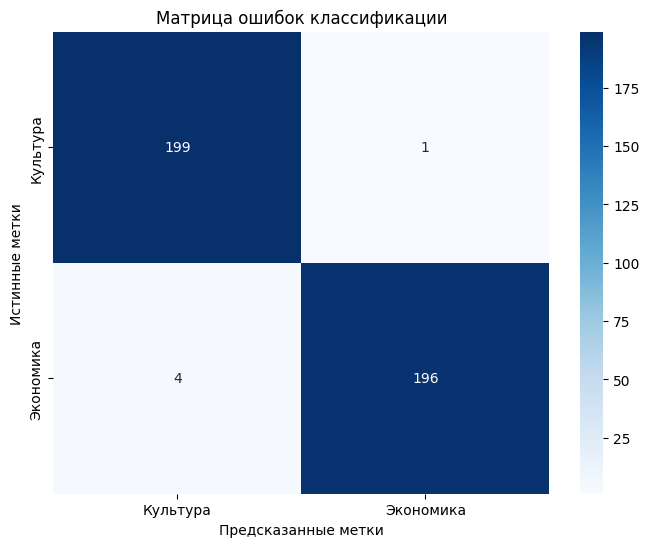


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:
Всего текстов в исходном датасете: 4000
Темы: ['Культура' 'Экономика']
Размер словаря TF-IDF: 5000 терминов
Размерность TF-IDF матрицы для классификации: (2000, 5000)

АНАЛИЗ ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ
Форма коэффициентов модели: (1, 5000)
Классы модели: ['Культура' 'Экономика']

Топ-15 признаков для темы 'Экономика' (положительные коэффициенты):
  1. процент (вес: 3.8192)
  2. компания (вес: 3.3873)
  3. рубль (вес: 2.6525)
  4. миллиард (вес: 2.3942)
  5. цена (вес: 2.2874)
  6. банк (вес: 2.1168)
  7. доллар (вес: 1.9256)
  8. рынок (вес: 1.8945)
  9. россия (вес: 1.8392)
  10. санкция (вес: 1.7756)
  11. сша (вес: 1.5948)
  12. пенсионный (вес: 1.4603)
  13. нефть (вес: 1.4160)
  14. рост (вес: 1.3764)
  15. газ (вес: 1.3438)

Топ-15 признаков для темы 'Культура' (отрицательные коэффициенты):
  1. фильм (вес: -3.1362)
  2. актер (вес: -2.7060)
  3. артист (вес: -2.4710)
  4. певица (вес: -2.2926)
  5. музыкант (вес: -1.9143)
  6. рэпер (вес: -1.8894)
  

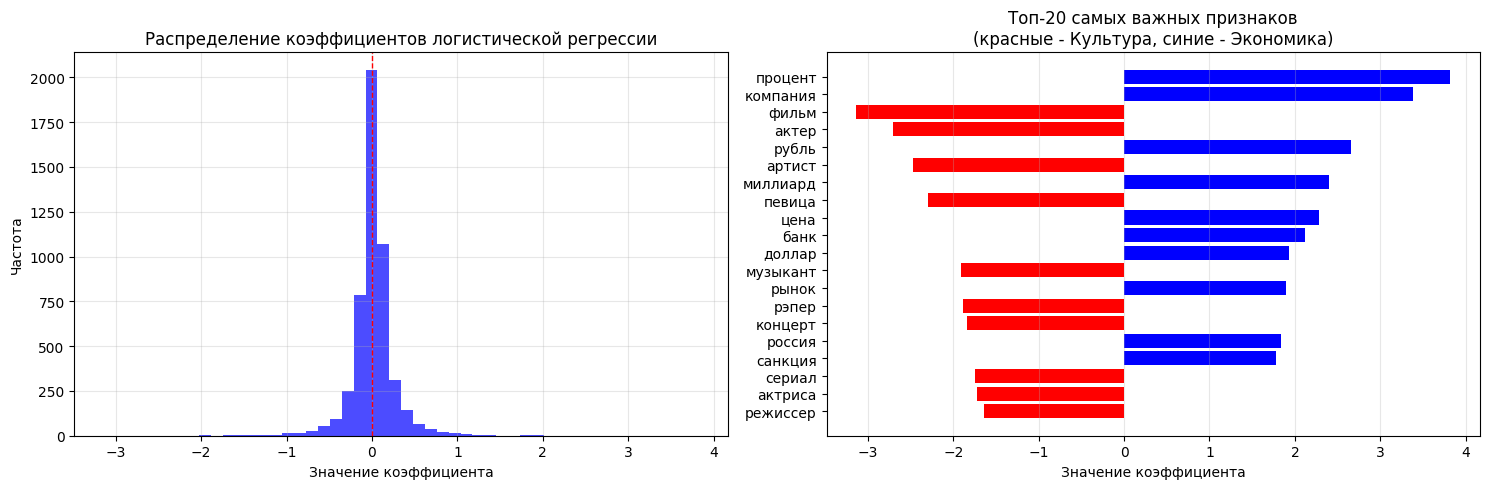


РАСПРЕДЕЛЕНИЕ ТЕМ В ВЫБОРКАХ:
Часть 1 (для словаря):
topic
Экономика    1000
Культура     1000
Name: count, dtype: int64

Часть 2 (для классификации):
topic
Культура     1000
Экономика    1000
Name: count, dtype: int64

Обучающая выборка:
Экономика    800
Культура     800
Name: count, dtype: int64

Валидационная выборка:
Культура     200
Экономика    200
Name: count, dtype: int64


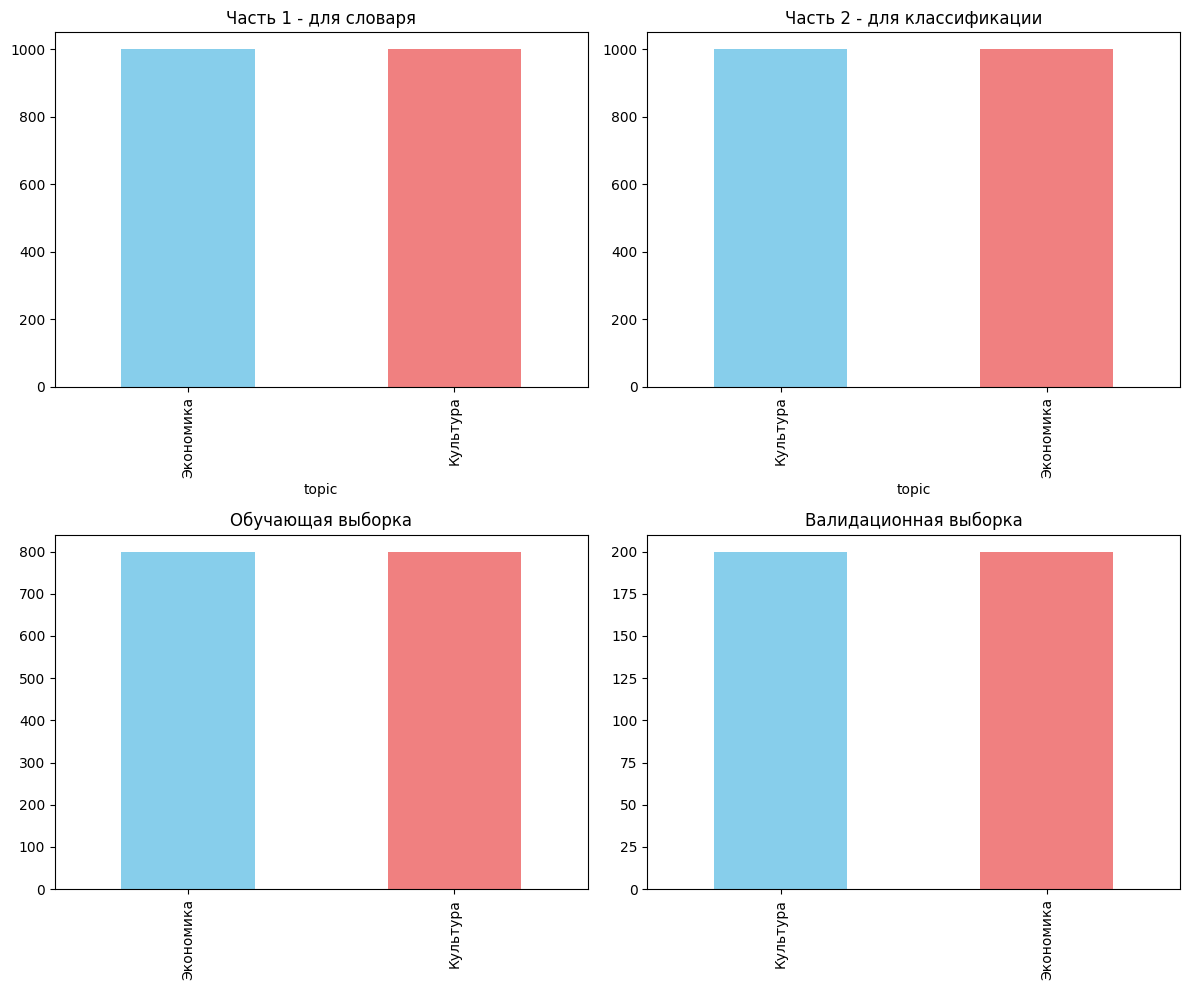

In [ ]:
# РАЗДЕЛЕНИЕ 1: Разбиваем на две части 1:1 для словаря и классификации
print("Разделение данных на две части 1:1...")
part1_df, part2_df = train_test_split(
    news,
    test_size=0.5,
    random_state=42,
    stratify=news['topic']
)

print(f"Часть 1 (для словаря): {len(part1_df)} текстов")
print(f"Часть 2 (для классификации): {len(part2_df)} текстов")

# Функция для токенизации текстов
def tokenize_texts(texts):
    """Преобразование текстов в список токенов"""
    tokenized_texts = []
    for text in texts:
        tokens = text.split()
        tokenized_texts.append(tokens)
    return tokenized_texts

# ШАГ 1: Построение словаря по первой части
print("\nШАГ 1: Построение словаря по первой части данных...")
part1_tokenized = tokenize_texts(part1_df['processed_text'].tolist())

# Строим словарь с ограничением в 5000 терминов
max_features = 5000
tfidf_matrix_part1, vocabulary, idf_dict = my_tfidf_vectorizer(part1_tokenized, max_features)

print(f"Размер словаря: {len(vocabulary)} терминов")

# ШАГ 2: Векторизация второй части с использованием построенного словаря
print("\nШАГ 2: Векторизация второй части данных...")
part2_tokenized = tokenize_texts(part2_df['processed_text'].tolist())

# Векторизуем вторую часть, используя словарь из первой части
tfidf_matrix_part2 = calculate_tfidf(part2_tokenized, vocabulary, idf_dict)
print(f"Размер TF-IDF матрицы для второй части: {tfidf_matrix_part2.shape}")

# ШАГ 3: Разделение второй части на обучающую и валидационную
print("\nШАГ 3: Разделение второй части на обучающую и валидационную...")
X = tfidf_matrix_part2
y = part2_df['topic'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} текстов")
print(f"Валидационная выборка: {X_test.shape[0]} текстов")

# ШАГ 4: Обучение логистической регрессии
print("\nШАГ 4: Обучение модели логистической регрессии...")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# ШАГ 5: Оценка качества классификации
print("\nШАГ 5: Оценка качества классификации...")
y_pred = logreg.predict(X_test)

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
print("Матрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Матрица ошибок классификации')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

# Дополнительная информация
print("\nДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"Всего текстов в исходном датасете: {len(news)}")
print(f"Темы: {news['topic'].unique()}")
print(f"Размер словаря TF-IDF: {len(vocabulary)} терминов")
print(f"Размерность TF-IDF матрицы для классификации: {X.shape}")

# Анализ признаков
print("\n" + "="*60)
print("АНАЛИЗ ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ")
print("="*60)

feature_names = list(vocabulary.keys())
coefficients = logreg.coef_[0]  # Берем первый (и единственный) набор коэффициентов

print(f"Форма коэффициентов модели: {logreg.coef_.shape}")
print(f"Классы модели: {logreg.classes_}")

# Для бинарной классификации в sklearn:
# Положительные коэффициенты -> класс с индексом 1 (Экономика)
# Отрицательные коэффициенты -> класс с индексом 0 (Культура)

# Топ признаков для Экономики (положительные коэффициенты)
top_economy_indices = np.argsort(coefficients)[-15:][::-1]
print(f"\nТоп-15 признаков для темы 'Экономика' (положительные коэффициенты):")
for j, idx in enumerate(top_economy_indices, 1):
    print(f"  {j}. {feature_names[idx]} (вес: {coefficients[idx]:.4f})")

# Топ признаков для Культуры (отрицательные коэффициенты)
top_culture_indices = np.argsort(coefficients)[:15]
print(f"\nТоп-15 признаков для темы 'Культура' (отрицательные коэффициенты):")
for j, idx in enumerate(top_culture_indices, 1):
    print(f"  {j}. {feature_names[idx]} (вес: {coefficients[idx]:.4f})")

# Самые сильные признаки по абсолютному значению
print(f"\nСамые сильные признаки (по абсолютному значению):")
abs_indices = np.argsort(np.abs(coefficients))[-20:][::-1]
for j, idx in enumerate(abs_indices, 1):
    class_association = "Экономика" if coefficients[idx] > 0 else "Культура"
    print(f"  {j}. {feature_names[idx]} (вес: {coefficients[idx]:.4f}, тема: {class_association})")

# Визуализация распределения коэффициентов
plt.figure(figsize=(15, 5))

# Гистограмма коэффициентов
plt.subplot(1, 2, 1)
plt.hist(coefficients, bins=50, alpha=0.7, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Распределение коэффициентов логистической регрессии')
plt.xlabel('Значение коэффициента')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

# Top-20 самых важных признаков (по абсолютному значению)
plt.subplot(1, 2, 2)
top_20_indices = np.argsort(np.abs(coefficients))[-20:][::-1]
top_20_features = [feature_names[idx] for idx in top_20_indices]
top_20_coeffs = [coefficients[idx] for idx in top_20_indices]

colors = ['red' if coef < 0 else 'blue' for coef in top_20_coeffs]
plt.barh(range(len(top_20_features)), top_20_coeffs, color=colors)
plt.yticks(range(len(top_20_features)), top_20_features)
plt.xlabel('Значение коэффициента')
plt.title('Топ-20 самых важных признаков\n(красные - Культура, синие - Экономика)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ распределения тем в выборках
print("\nРАСПРЕДЕЛЕНИЕ ТЕМ В ВЫБОРКАХ:")
print("Часть 1 (для словаря):")
print(part1_df['topic'].value_counts())
print("\nЧасть 2 (для классификации):")
print(part2_df['topic'].value_counts())
print("\nОбучающая выборка:")
print(pd.Series(y_train).value_counts())
print("\nВалидационная выборка:")
print(pd.Series(y_test).value_counts())

# Визуализация распределения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Часть 1
part1_df['topic'].value_counts().plot(kind='bar', ax=axes[0,0], title='Часть 1 - для словаря', color=['skyblue', 'lightcoral'])

# Часть 2
part2_df['topic'].value_counts().plot(kind='bar', ax=axes[0,1], title='Часть 2 - для классификации', color=['skyblue', 'lightcoral'])

# Обучающая
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[1,0], title='Обучающая выборка', color=['skyblue', 'lightcoral'])

# Валидационная
pd.Series(y_test).value_counts().plot(kind='bar', ax=axes[1,1], title='Валидационная выборка', color=['skyblue', 'lightcoral'])

plt.tight_layout()
plt.show()


**Задание 3.** Используя модуль TfIdfVectorizer библиотеки sklearn, сделайте классификацию новостных текстов из предыдущей лабораторной работы. Предусмотрите предобработку текстов и задание ограничение словаря при взвешивании. Оцените качество классификации. Подробнее прочитать про базовую обработку и векторизацию текстов можно в <a href="https://github.com/Yorko/mlcourse.ai/blob/main/jupyter_russian/tutorials/vectorizers_tutorial_mvsamsonov.ipynb">руководстве</a>..

Используем данные из задания 2...
Часть 2 (для классификации): 2000 текстов
Обучающая выборка: 1600 текстов
Тестовая выборка: 400 текстов

Создание TfidfVectorizer с ограничением словаря...
Векторизация текстов...
Размерность обучающей матрицы: (1600, 5000)
Размерность тестовой матрицы: (400, 5000)
Размер словаря: 5000

Обучение модели логистической регрессии...
Оценка качества классификации...
Точность (Accuracy): 0.9900

Подробный отчет по классификации:
              precision    recall  f1-score   support

    Культура       0.99      0.99      0.99       200
   Экономика       0.99      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



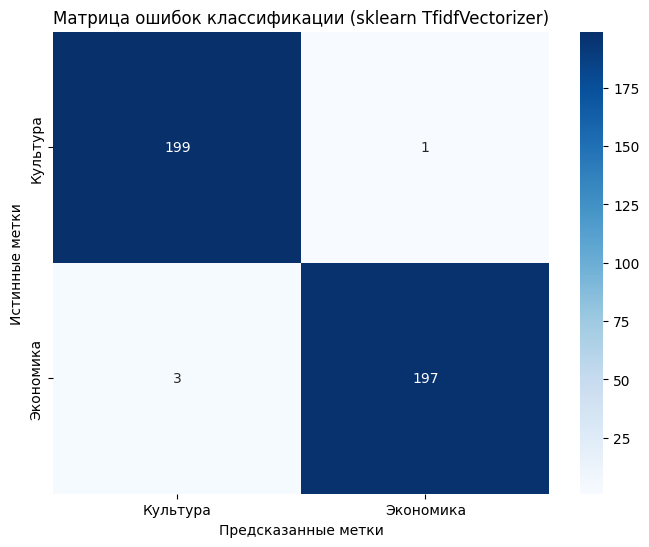


Анализ наиболее важных признаков...

Топ-15 признаков для темы 'Экономика' (sklearn):
  1. компания (вес: 3.2345)
  2. процент (вес: 3.1829)
  3. рубль (вес: 2.1283)
  4. миллиард (вес: 2.0531)
  5. банк (вес: 1.9530)
  6. цена (вес: 1.8732)
  7. рынок (вес: 1.6760)
  8. россия (вес: 1.5854)
  9. доллар (вес: 1.5440)
  10. санкция (вес: 1.5031)
  11. сша (вес: 1.3676)
  12. пенсионный (вес: 1.2907)
  13. решение (вес: 1.2392)
  14. глава (вес: 1.2363)
  15. нефть (вес: 1.1820)

Топ-15 признаков для темы 'Культура' (sklearn):
  1. фильм (вес: -2.8571)
  2. актер (вес: -2.4925)
  3. артист (вес: -2.3188)
  4. певица (вес: -2.0201)
  5. музыкант (вес: -1.9574)
  6. концерт (вес: -1.7469)
  7. рэпер (вес: -1.7412)
  8. сериал (вес: -1.5711)
  9. режиссер (вес: -1.5654)
  10. картина (вес: -1.5302)
  11. актриса (вес: -1.4909)
  12. песня (вес: -1.3750)
  13. известный (вес: -1.3690)
  14. артистка (вес: -1.2039)
  15. роль (вес: -1.1547)

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Собственная реализация TF-ID

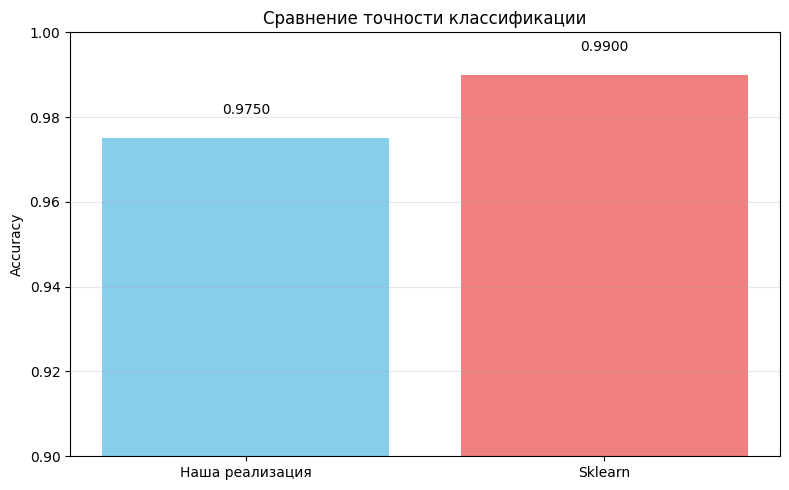

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Используем данные из задания 2
print("Используем данные из задания 2...")
print(f"Часть 2 (для классификации): {len(part2_df)} текстов")

# Берем тексты из part2_df для классификации
X_texts = part2_df['processed_text'].tolist()
y = part2_df['topic'].values

# Разделяем на обучающую и тестовую выборки (как в задании 2)
from sklearn.model_selection import train_test_split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X_texts, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {len(X_train_texts)} текстов")
print(f"Тестовая выборка: {len(X_test_texts)} текстов")

# Создание TfidfVectorizer с ограничением словаря
print("\nСоздание TfidfVectorizer с ограничением словаря...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Ограничение размера словаря (как в задании 2)
    min_df=2,           # Минимальная частота термина
    max_df=0.85,        # Максимальная частота термина
    ngram_range=(1, 1)  # Используем только униграммы для сравнения
)

# Преобразование текстов в TF-IDF матрицы
print("Векторизация текстов...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

print(f"Размерность обучающей матрицы: {X_train_tfidf.shape}")
print(f"Размерность тестовой матрицы: {X_test_tfidf.shape}")
print(f"Размер словаря: {len(tfidf_vectorizer.get_feature_names_out())}")

# Обучение модели логистической регрессии
print("\nОбучение модели логистической регрессии...")
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train_tfidf, y_train)

# Предсказание и оценка качества
print("Оценка качества классификации...")
y_pred = logreg.predict(X_test_tfidf)

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.4f}")

print("\nПодробный отчет по классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Матрица ошибок классификации (sklearn TfidfVectorizer)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

# Анализ наиболее важных признаков
print("\nАнализ наиболее важных признаков...")
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logreg.coef_[0]  # Для бинарной классификации

# Топ признаков для Экономики (положительные коэффициенты)
top_economy_indices = np.argsort(coefficients)[-15:][::-1]
print(f"\nТоп-15 признаков для темы 'Экономика' (sklearn):")
for j, idx in enumerate(top_economy_indices, 1):
    print(f"  {j}. {feature_names[idx]} (вес: {coefficients[idx]:.4f})")

# Топ признаков для Культуры (отрицательные коэффициенты)
top_culture_indices = np.argsort(coefficients)[:15]
print(f"\nТоп-15 признаков для темы 'Культура' (sklearn):")
for j, idx in enumerate(top_culture_indices, 1):
    print(f"  {j}. {feature_names[idx]} (вес: {coefficients[idx]:.4f})")

# Сравнение с нашей реализацией из задания 2
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)
print("Собственная реализация TF-IDF (Задание 2):")
print("- Точность: 0.9750")
print("- Размер словаря: 5000")
print(f"\nSklearn TfidfVectorizer (Задание 3):")
print(f"- Точность: {accuracy:.4f}")
print(f"- Размер словаря: {len(tfidf_vectorizer.get_feature_names_out())}")

# Визуализация сравнения
methods = ['Наша реализация', 'Sklearn']
scores = [0.9750, accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, scores, color=['skyblue', 'lightcoral'])
plt.title('Сравнение точности классификации')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)

# Добавляем значения на столбцы
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 4.** Постройте график зависимости значения `accuracy` от размера словаря, по которому выполняется tf-idf векторизация. Для этого используйте первую и вторую выборки исходного датасета, которые были получены при первом разбиении в предыдущем задании. По первой части текстов один раз строите словарь `D_common`, потом из него формируете словарь `D_k` размером `k`. По словарю `D_k` векторизуете вторую часть текстов, затем по которой обучаете и проверяете качество модели. Значение `k` меняется от [500, 1000, 1500, 2000, 3000, 5000].

Исследуем зависимость точности от размера словаря...

Размер словаря: 500
  Размерность матрицы: (1600, 500)
  Точность: 0.9800

Размер словаря: 1000
  Размерность матрицы: (1600, 1000)
  Точность: 0.9875

Размер словаря: 1500
  Размерность матрицы: (1600, 1500)
  Точность: 0.9875

Размер словаря: 2000
  Размерность матрицы: (1600, 2000)
  Точность: 0.9875

Размер словаря: 3000
  Размерность матрицы: (1600, 3000)
  Точность: 0.9900

Размер словаря: 5000
  Размерность матрицы: (1600, 5000)
  Точность: 0.9900

Результаты исследования:
   Размер словаря  Точность
0             500    0.9800
1            1000    0.9875
2            1500    0.9875
3            2000    0.9875
4            3000    0.9900
5            5000    0.9900


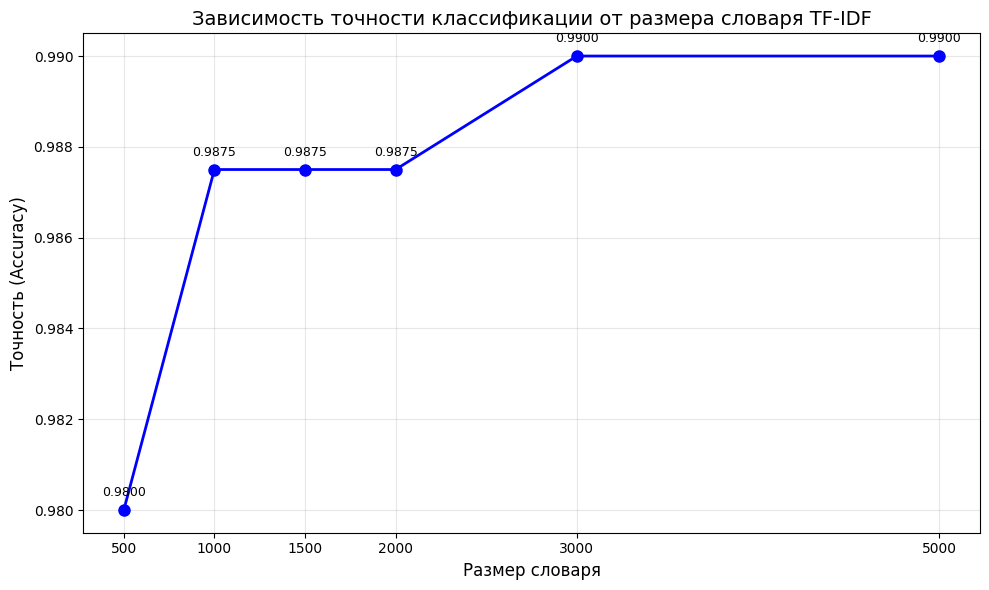


АНАЛИЗ РЕЗУЛЬТАТОВ:
Лучшая точность: 0.9900 при размере словаря 3000
Худшая точность: 0.9800 при размере словаря 500
Улучшение точности при увеличении словаря с 500 до 5000: 0.0100


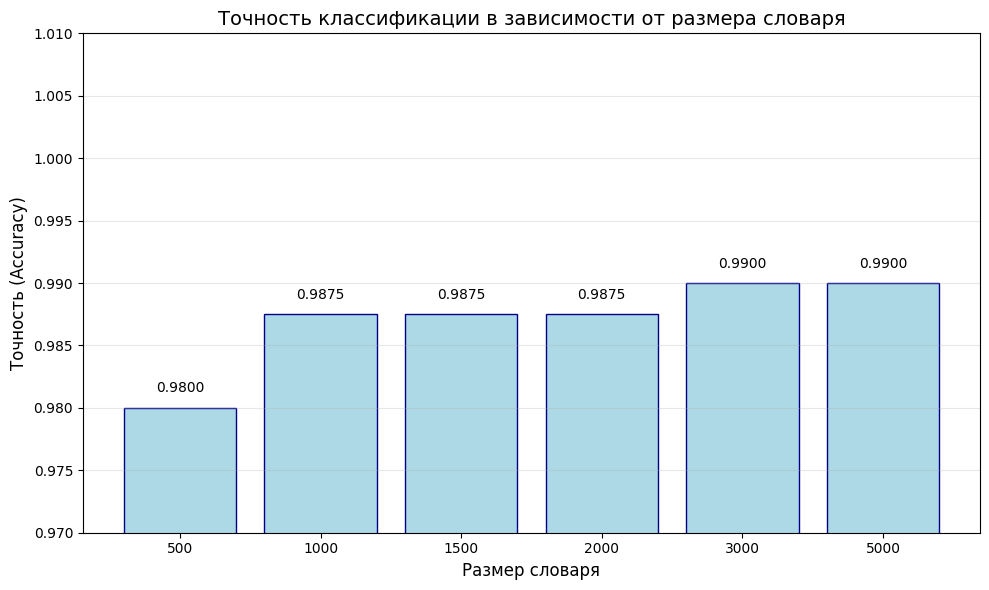

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np

# Размеры словарей для исследования
k_list = [500, 1000, 1500, 2000, 3000, 5000]
accuracies = []

print("Исследуем зависимость точности от размера словаря...")

for k in k_list:
    print(f"\nРазмер словаря: {k}")

    # Создаем TfidfVectorizer с текущим размером словаря
    tfidf_vectorizer_k = TfidfVectorizer(
        max_features=k,
        min_df=2,
        max_df=0.85,
        ngram_range=(1, 1)
    )

    # Векторизация обучающих данных
    X_train_tfidf_k = tfidf_vectorizer_k.fit_transform(X_train_texts)

    # Векторизация тестовых данных
    X_test_tfidf_k = tfidf_vectorizer_k.transform(X_test_texts)

    print(f"  Размерность матрицы: {X_train_tfidf_k.shape}")

    # Обучение модели
    logreg_k = LogisticRegression(random_state=42, max_iter=1000)
    logreg_k.fit(X_train_tfidf_k, y_train)

    # Предсказание и оценка
    y_pred_k = logreg_k.predict(X_test_tfidf_k)
    accuracy_k = accuracy_score(y_test, y_pred_k)
    accuracies.append(accuracy_k)

    print(f"  Точность: {accuracy_k:.4f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Размер словаря': k_list,
    'Точность': accuracies
})

print("\nРезультаты исследования:")
print(results_df)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_list, accuracies, 'o-', linewidth=2, markersize=8, color='blue')
plt.title('Зависимость точности классификации от размера словаря TF-IDF', fontsize=14)
plt.xlabel('Размер словаря', fontsize=12)
plt.ylabel('Точность (Accuracy)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_list)

# Добавляем аннотации с значениями точности
for i, (k, acc) in enumerate(zip(k_list, accuracies)):
    plt.annotate(f'{acc:.4f}', (k, acc), textcoords="offset points",
                 xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Анализ результатов
print("\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print("="*40)
max_acc_index = np.argmax(accuracies)
min_acc_index = np.argmin(accuracies)

print(f"Лучшая точность: {accuracies[max_acc_index]:.4f} при размере словаря {k_list[max_acc_index]}")
print(f"Худшая точность: {accuracies[min_acc_index]:.4f} при размере словаря {k_list[min_acc_index]}")

# Анализ роста точности
if len(accuracies) > 1:
    improvement = accuracies[-1] - accuracies[0]
    print(f"Улучшение точности при увеличении словаря с {k_list[0]} до {k_list[-1]}: {improvement:.4f}")

# Визуализация в виде столбчатой диаграммы
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(k_list)), accuracies, color='lightblue', edgecolor='darkblue')
plt.title('Точность классификации в зависимости от размера словаря', fontsize=14)
plt.xlabel('Размер словаря', fontsize=12)
plt.ylabel('Точность (Accuracy)', fontsize=12)
plt.xticks(range(len(k_list)), k_list)

# Добавляем значения на столбцы
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.02)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Задание 5.** Реализуйте поиск новостных текстов по текстовому запросу, задаваемому пользователем, на основе tf-idf векторизации (можно использовать любую реализацию методов).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Инициализация поисковой системы
X_all_tfidf = tfidf_vectorizer.transform(part2_df['processed_text'].tolist())

print(f"Поисковая система готова. База: {len(part2_df)} новостей")

# Функция поиска
def search_news(query, top_n=5):
    processed_query = preprocess_text(query)
    query_vector = tfidf_vectorizer.transform([processed_query])
    similarities = cosine_similarity(query_vector, X_all_tfidf).flatten()
    top_indices = np.argsort(similarities)[-top_n:][::-1]

    results = []
    for i, idx in enumerate(top_indices):
        if similarities[idx] > 0:
            doc = part2_df.iloc[idx]
            results.append({
                'rank': i + 1,
                'similarity': similarities[idx],
                'title': doc['title'],
                'topic': doc['topic'],
                'text': doc['text'][:150] + '...',
                'url': doc['url']
            })
    return results

# Интерактивный поиск
print("\nИНТЕРАКТИВНЫЙ ПОИСК НОВОСТЕЙ")
print("Введите поисковый запрос (для выхода введите 'выход' или нажмите Ctrl+C):")

try:
    while True:
        query = input("\nЗапрос: ").strip()

        if query.lower() == 'выход':
            print("Завершение работы поисковой системы...")
            break

        if not query:
            print("Введите непустой запрос")
            continue

        print(f"\nРезультаты поиска для: '{query}'")
        print("-" * 50)

        results = search_news(query, top_n=5)

        if not results:
            print("По вашему запросу ничего не найдено.")
        else:
            for result in results:
                print(f"\n{result['rank']}. [{result['topic']}] {result['title']}")
                print(f"   Схожесть: {result['similarity']:.4f}")
                print(f"   {result['text']}")

except KeyboardInterrupt:
    print("\n\nЗавершение работы по команде пользователя...")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Поисковая система готова. База: 2000 новостей

ИНТЕРАКТИВНЫЙ ПОИСК НОВОСТЕЙ
Введите поисковый запрос (для выхода введите 'выход' или нажмите Ctrl+C):

Запрос: процент

Результаты поиска для: 'процент'
--------------------------------------------------

1. [Экономика] Названы главные беды автомобилистов
   Схожесть: 0.6938
   Автовладельцев больше всего в работе автосервисов своих дилеров не устраивают высокие цены и изменение стоимости в процессе ремонта. Как показало иссл...

2. [Экономика] Названы самые быстро дорожающие продукты
   Схожесть: 0.6707
   С декабря прошлого года сильнее всего подорожало пшено. Как следует из отчета Росстата, цены на него поднялись на 40,9 процента. На 40,3 процента подо...

3. [Экономика] Большинству россиян подняли зарплаты
   Схожесть: 0.5810
   У абсолютного большинства россиян в 2018 году выросла зарплата. По крайней мере об этом говорит 61 процент опрошенных компанией Hays работодателей (ко...

4. [Экономика] Российская экономика испугалась америка